In [1]:
import os
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from dataset.dataset import load_mnist

import tensorflow as tf
import numpy as np

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def gen_params():
    return tf.contrib.training.HParams(
        z_size=100,    # 隐变量维度
        batch_size=128,
        lr=1e-3
    )

params=gen_params()

train_data,test_data=load_mnist(batch_size=params.batch_size)    # 注意MNIST尺寸是28*28


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(60000, 784) (60000,)
(10000, 784) (10000,)


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## 网络设计

In [3]:
unit_I_G = params.z_size    # 生成器输入为隐变量
unit_I_D = train_data.n_features    # 判别器输入为图片

unit_h = 256    # 隐含层

unit_O_G = unit_I_D    # 生成器输出为图片
unit_O_D = 1    # 判别器输出为二分类

## 功能函数

In [4]:
def noise_gen(n_samples, z_size):
    '''
    隐变量生成器
    '''
    return np.random.uniform(-1, 1, size=(n_samples, z_size))

## 网络搭建

In [33]:
tf.reset_default_graph()     # 清空图

Z = tf.placeholder(tf.float32, shape=[None, unit_I_G])   # 判别器输入，即隐变量
X = tf.placeholder(tf.float32, shape=[None, unit_I_D])    # 真实图片输入

In [ ]:
with tf.name_scope('GAN'):
    def generator(z):
        '''
        生成器，用于生成伪造数据
        z: 隐变量
        返回伪造的图片
        '''
        with tf.variable_scope('Generator'):
            hidden_layer_G = tf.layers.dense(z, unit_h,
                                             activation=tf.nn.leaky_relu)
            img_gen = tf.layers.dense(hidden_layer_G, unit_O_G,
                                      activation=tf.nn.sigmoid)
            return img_gen

    def discriminator(x):
        '''
        判别器，其接收两套输入，参数需要重用
        x: 数据
        返回对数据的判别分数
        '''
        with tf.variable_scope('Discrimator', reuse=tf.AUTO_REUSE):
            hidden_layer_D = tf.layers.dense(x, unit_h,
                                             activation=tf.nn.leaky_relu)
            logits_D = tf.layers.dense(hidden_layer_D, unit_O_D,
                                       activation=None)
            return logits_D

    img_fake = generator(Z)    # 生成假图像
    logit_real = discriminator(X)    # 判别器对于真实图像的打分(None, 1)
    logit_fake = discriminator(img_fake)    # 判别器对于假图像的打分(None, 1)

    vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope='Generator')
    vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope='Discrimator')

In [5]:
with tf.name_scope('Eval'):
    # 这里稍微修改了VanillaGAN的损失函数
    loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logit_real,
        labels=tf.ones_like(logit_real)) +
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logit_fake,
            labels=tf.zeros_like(logit_fake)))
    loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logit_fake,
        labels=tf.ones_like(logit_fake)))

with tf.name_scope('train_op'):
    train_op_G = tf.train.AdamOptimizer(params.lr) \
        .minimize(loss_G, var_list=vars_G)
    train_op_D = tf.train.AdamOptimizer(params.lr) \
        .minimize(loss_D, var_list=vars_D)


def get_sess():
    init = tf.global_variables_initializer()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True    # 按需使用显存
    sess = tf.Session(config=config)
    sess.run(init)
    return sess

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


## 训练网络

In [6]:
sess = get_sess()
epochs = 50

batch_cnt = 0
for epoch in range(epochs):
    for batch_data, _ in train_data.next_batch():
        batch_cnt += 1
        img_gen, loss_val_G, _ = sess.run([img_fake, loss_G, train_op_G],
                                          feed_dict={Z: noise_gen(len(batch_data), unit_I_G)})
        loss_val_D, _ = sess.run([loss_D, train_op_D],
                                 feed_dict={X: batch_data,
                                            Z: noise_gen(len(batch_data), unit_I_G)})

        # 每1000batch输出一次信息
        if (batch_cnt+1) % 1000 == 0:
            print('epoch: {}, batch_loss_D: {}, batch_loss_G: {}'
                  .format(epoch+1, loss_val_D, loss_val_G))

epoch: 3, batch_loss_D: 0.013341275043785572, batch_loss_G: 8.079753875732422
epoch: 5, batch_loss_D: 0.0714440792798996, batch_loss_G: 7.159387588500977
epoch: 7, batch_loss_D: 0.07087362557649612, batch_loss_G: 5.00454044342041
epoch: 9, batch_loss_D: 0.23719283938407898, batch_loss_G: 4.534101486206055
epoch: 11, batch_loss_D: 0.22911125421524048, batch_loss_G: 4.333502769470215
epoch: 13, batch_loss_D: 0.2831006348133087, batch_loss_G: 3.5485315322875977
epoch: 15, batch_loss_D: 0.3772451877593994, batch_loss_G: 3.2124462127685547
epoch: 18, batch_loss_D: 0.32349157333374023, batch_loss_G: 3.6719970703125
epoch: 20, batch_loss_D: 0.3813501000404358, batch_loss_G: 3.560455799102783
epoch: 22, batch_loss_D: 0.47473835945129395, batch_loss_G: 2.5338172912597656
epoch: 24, batch_loss_D: 0.408947229385376, batch_loss_G: 2.983705997467041
epoch: 26, batch_loss_D: 0.45593810081481934, batch_loss_G: 3.096835136413574
epoch: 28, batch_loss_D: 0.42863065004348755, batch_loss_G: 2.94949054718

<Figure size 432x288 with 0 Axes>

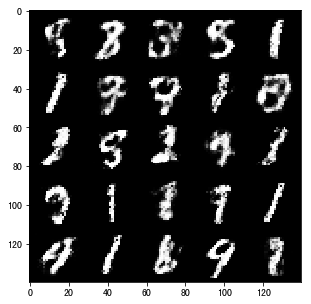

In [32]:
# 生成不同范围的二维输入，生成图片
n = 5
x_axis = np.linspace(-1, 1, n)
y_axis = np.linspace(-1, 1, n)
canvas = np.empty((28 * n, 28 * n))    # 画布，不同区域填充不同的图片

for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        x_mean = sess.run(img_fake,feed_dict={Z:noise_gen(1,unit_I_G)})
        canvas[(n - i - 1) * 28:(n - i) * 28, j *
               28:(j + 1) * 28] = x_mean[0].reshape(28, 28)

import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(5, 5))
plt.imshow(canvas, cmap='gray')
plt.show()

In [9]:
sess.close()